## Task 1

For the linear layer we need two derivates towards the trainable parameters
\begin{align}
\frac{\partial f_j}{\partial b_j}&=1\\
\frac{\partial f_j}{\partial w_{ji}}&=x_i
\end{align}
and one towards the input
\begin{equation}
\frac{\partial f_j}{\partial x_i}=w_{ji}
\end{equation}


For the ReLU unit $g=\max\left(0,f\right)$ we have the following gradient:
\begin{equation}
\frac{\partial g}{\partial f}=
\begin{cases}
    1 & \text{if}~f>0\\
    0 & \text{if}~f<0
\end{cases}
\end{equation}
Keep in mind that the derivative at $f=0$ does not exists.


In [8]:
#do all imports here
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm #status bar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#define single layers
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights and biases
        # https://pytorch.org/docs/stable/nn.init.html
        self.weight = torch.randn(1, out_channels, in_channels)/(in_channels+1)
        self.bias = torch.zeros(1, out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # https://pytorch.org/docs/stable/generated/torch.einsum.html
        # https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum    
        return torch.einsum("bji,bi->bj", self.weight, x)+self.bias
    
    def backward(self, gradient):
        self.grad_weight = torch.mean(torch.einsum("bj,bi->bji", gradient, self.last_input), dim=0)
        self.grad_bias = torch.mean(gradient, dim=0) # gradient * 1

        # return the grad to next layer
        # upper grad mm the grad towards the input
        return torch.einsum("bj,bji->bi", gradient, self.weight)
    
    def update(self, learning_rate):
        # gradient descent
        self.weight = self.weight - learning_rate*self.grad_weight
        self.bias = self.bias - learning_rate*self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        return torch.maximum(x, torch.zeros_like(x)) #elementwise maximum
    
    def backward(self, gradient):
        # takes the gradient and multiplies it with the gradient of the ReLU function (1 if x>0, 0 otherwise)
        return gradient*torch.where(self.last_input>0.0, 1.0, 0.0)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
    
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        # x = torch.exp(x-torch.amax(x)) #numerical stable version -> normalize by max(x)
        x = torch.exp(x-torch.amax(x, dim=-1,keepdims=True)) #numerical stable version -> normalize by max(x)
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

In [2]:
intermediate = torch.randn(100, 2)

def softmax_unstable(x):
    x = torch.exp(x-torch.amax(x))
    return x/(torch.sum(x, dim=-1, keepdim=True)+1e-12)

### small illustration when the softmax is unstable

In [3]:
softmax_unstable(intermediate)

tensor([[0.7159, 0.2841],
        [0.6138, 0.3862],
        [0.5927, 0.4073],
        [0.1255, 0.8745],
        [0.0832, 0.9168],
        [0.9113, 0.0887],
        [0.9250, 0.0750],
        [0.4652, 0.5348],
        [0.4818, 0.5182],
        [0.2561, 0.7439],
        [0.8378, 0.1622],
        [0.7456, 0.2544],
        [0.7218, 0.2782],
        [0.3288, 0.6712],
        [0.8700, 0.1300],
        [0.0912, 0.9088],
        [0.1835, 0.8165],
        [0.1566, 0.8434],
        [0.7927, 0.2073],
        [0.2215, 0.7785],
        [0.0817, 0.9183],
        [0.3618, 0.6382],
        [0.6681, 0.3319],
        [0.6952, 0.3048],
        [0.2692, 0.7308],
        [0.8492, 0.1508],
        [0.6462, 0.3538],
        [0.2999, 0.7001],
        [0.9712, 0.0288],
        [0.0331, 0.9669],
        [0.6292, 0.3708],
        [0.3615, 0.6385],
        [0.5628, 0.4372],
        [0.5715, 0.4285],
        [0.6211, 0.3789],
        [0.1267, 0.8733],
        [0.4544, 0.5456],
        [0.0293, 0.9707],
        [0.7

In [5]:
intermediate[0][0] = 200
softmax_unstable(intermediate)

tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [6]:
def softmax_stable(x):
    x = torch.exp(x-torch.amax(x, dim=-1, keepdims=True))
    return x/(torch.sum(x, dim=-1, keepdims=True)+1e-12)

In [7]:
softmax_stable(intermediate)

tensor([[1.0000, 0.0000],
        [0.6138, 0.3862],
        [0.5927, 0.4073],
        [0.1255, 0.8745],
        [0.0832, 0.9168],
        [0.9113, 0.0887],
        [0.9250, 0.0750],
        [0.4652, 0.5348],
        [0.4818, 0.5182],
        [0.2561, 0.7439],
        [0.8378, 0.1622],
        [0.7456, 0.2544],
        [0.7218, 0.2782],
        [0.3288, 0.6712],
        [0.8700, 0.1300],
        [0.0912, 0.9088],
        [0.1835, 0.8165],
        [0.1566, 0.8434],
        [0.7927, 0.2073],
        [0.2215, 0.7785],
        [0.0817, 0.9183],
        [0.3618, 0.6382],
        [0.6681, 0.3319],
        [0.6952, 0.3048],
        [0.2692, 0.7308],
        [0.8492, 0.1508],
        [0.6462, 0.3538],
        [0.2999, 0.7001],
        [0.9712, 0.0288],
        [0.0331, 0.9669],
        [0.6292, 0.3708],
        [0.3615, 0.6385],
        [0.5628, 0.4372],
        [0.5715, 0.4285],
        [0.6211, 0.3789],
        [0.1267, 0.8733],
        [0.4544, 0.5456],
        [0.0293, 0.9707],
        [0.7

In [4]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

### Training

100%|██████████| 250/250 [00:14<00:00, 17.86it/s]


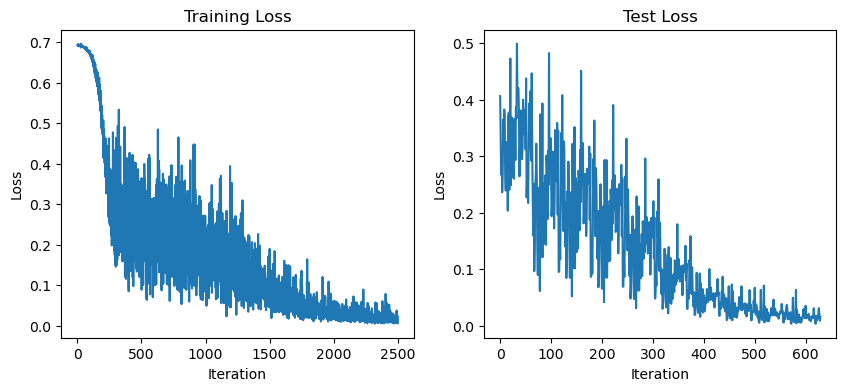

In [8]:
#create datasets
from sklearn.datasets import make_moons

Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

#rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5


batch_size = 32
num_batches_train = int(np.ceil(Ntrain/batch_size))
num_batches_test = int(np.ceil(Ntest/batch_size))

num_epochs = 10

mlp = MLP(2, [30,30], 2)
learning_rate = 5e-2


#train network
losses_train = []
losses_test = []
for epoch in range(num_epochs):
    #reshuffle training data
    ind = np.random.permutation(len(Xtrain))
    Xtrain = Xtrain[ind]
    ytrain = ytrain[ind]
    #training pass
    for it in tqdm(range(num_batches_train)):
        start = it*batch_size
        end = min((it+1)*batch_size, len(Xtrain))
        X = torch.FloatTensor(Xtrain[start:end])
        y = torch.LongTensor(ytrain[start:end])
        
        loss = mlp.training_step(X, y, learning_rate) #do one iteration of training
        
        losses_train.append(loss.item())
    
    #testing pass
    for it in range(num_batches_test):
        start = it*batch_size
        end = min((it+1)*batch_size, len(Xtest))
        X = torch.FloatTensor(Xtest[start:end])
        y = torch.LongTensor(ytest[start:end])
        
        probabilities = mlp.forward(X) #predict
        loss = mlp.criterion.forward(probabilities, y)
        
        losses_test.append(loss.item())
    
        
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(losses_train)

plt.subplot(1,2,2)
plt.title("Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(losses_test)


## Task 2


First some basic helpers


In [9]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm  # Not needed but very cool!
from matplotlib import pyplot as plt
import time


def load_data(train=True):
    mnist = datasets.MNIST('../data',
                           train=train,
                           download=True)
    return mnist

def alternative_convert(data):
    data_tensor = data.data
    start = time.time()
    out = (data_tensor.float() / 127.5 - 1.).numpy().reshape(data_tensor.shape[0],-1)
    print(f'Conversion took {time.time()-start} secs')
    return out, data.targets.numpy().astype(int)

def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their 
       eigenvalues in decreasing order.
    '''

    #mnist_vectors, labels = convert_mnist_to_vectors(data)
    mnist_vectors, labels = alternative_convert(data)
#     prepare_data(mnist_vectors)
	
    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:,sorted_index]
    #print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

/Users/pingchuanma/miniconda/envs/sandbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1 Plot some data

This is always important before starting to work with it. Always make sure, that your data comes in the way you want it to be.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9489277.07it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 271916.24it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2906488.85it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 746026.35it/s]
/var/folders/0g/sjsyz92j6dj4ph96wz0jwzd00000gn/T/ipykernel_60383/3920742442.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Statistics:
Min value 0
Max value 255
Mean value 33.31842041015625
Shape (60000, 28, 28)
Data type torch.uint8


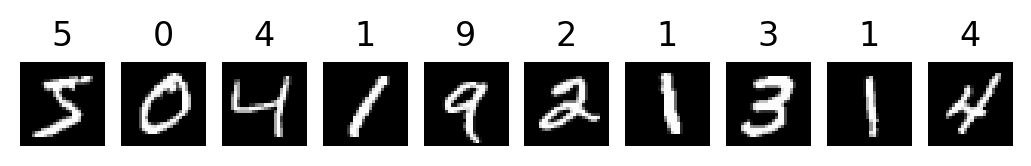

In [10]:
data = load_data()

def plot_examples(data):
    # Plot some examples and put their corresponding label on top as title.
    fig, axs = plt.subplots(1,10, dpi=200)
    for i in range(10):
        img = data.data[i]
        class_id = data.targets[i]
        axs[i].imshow(img,cmap='gray')
        axs[i].set_title(str(class_id.item()))
        axs[i].axis('off')
        
    fig.show()
    # Also print some statistics
    print('Statistics:')
    print('Min value',int(data.data.min()))
    print('Max value',int(data.data.max()))
    print('Mean value',float(data.data.float().mean()))
    print('Shape',tuple(data.data.shape))
    print('Data type',data.data.dtype)
    
plot_examples(data)

### 2.2 Convert the data to numpy arrays

In [11]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where 
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []
    
    iT = transforms.ToTensor()
    start = time.time()
    for image, label in tqdm(data):
        # apply transform
        image = iT(image)
        mnist_vectors.append((image * 2 - 1.).numpy())
        labels.append(label)

    
    mnist_vectors=np.stack(mnist_vectors).reshape(len(mnist_vectors),-1)
    labels = np.asarray(labels,dtype=int)
    print(f'Conversion took {time.time()-start} secs')
    return mnist_vectors, labels

mnist_vectors, labels = convert_mnist_to_vectors(data)
print(f'New min {mnist_vectors.min()}')
print(f'New max {mnist_vectors.max()}')

  0%|          | 0/60000 [00:00<?, ?it/s]

Conversion took 6.17158055305481 secs
New min -1.0
New max 1.0


...some more efficient conversion function 

In [11]:
def alternative_convert(data):
    data_tensor = data.data
    start = time.time()
    out = (data_tensor.float() / 127.5 - 1.).numpy().reshape(data_tensor.shape[0],-1)
    print(f'Conversion took {time.time()-start} secs')
    return out, data.targets.numpy().astype(int)

mnist_vectors, labels = alternative_convert(data)
print(f'New min {mnist_vectors.min()}')
print(f'New max {mnist_vectors.max()}')

Conversion took 0.16852617263793945 secs
New min -1.0
New max 1.0


### 2.3 Visualize Principal Components
can also check here how do the PCAs look like for simple face: https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/



Conversion took 0.1290280818939209 secs
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/0g/sjsyz92j6dj4ph96wz0jwzd00000gn/T/ipykernel_60383/1551535428.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


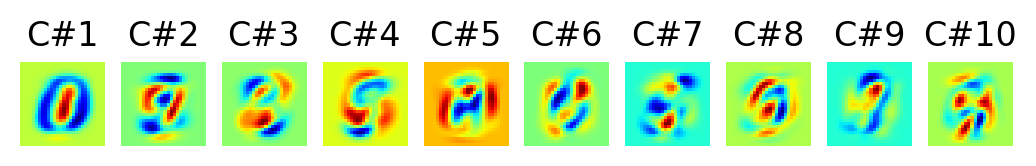

In [16]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''

    # we plot the first 10 principal components
    # reshape them back to 28x28 as images
    first_pcs = sorted_eigenVectors[:num].reshape(-1,28,28)
    fig, axs = plt.subplots(1,10, dpi=200)
    for i, pc in enumerate(first_pcs):
        axs[i].imshow(pc.astype(np.float32),cmap='jet')
        axs[i].set_title(f'C#{i+1}')
        axs[i].axis('off')
    
    fig.show()
     
sorted_ev = do_pca(data)
plot_pcs(sorted_ev)


### 2.4 Projection of the Datatset

Conversion took 0.09290909767150879 secs
(784, 784)


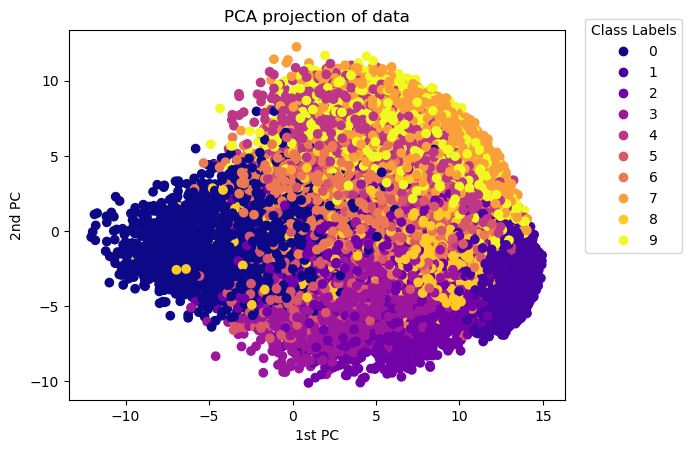

In [20]:
def plot_projection(sorted_eigenVectors, data, convert_to_vectors=True):
    '''Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
    a scatterplot of the resulting points'''
    if convert_to_vectors:
        mnist_vectors, labels = alternative_convert(data)
    else:
        mnist_vectors, labels = data
    print(sorted_eigenVectors.shape)

    first_two = sorted_eigenVectors.T[...,:2]

    # project data onto the first two principal components
    projected_data = np.dot(mnist_vectors,first_two)
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(projected_data[:,0],projected_data[:,1], c=labels, cmap='plasma')
    
    
    ax.set_title('PCA projection of data')
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    ax.legend(*scatter.legend_elements(),
             title='Class Labels',
             loc='upper right',
             bbox_to_anchor=(1.25, 1.05))
        
    fig.show()

plot_projection(sorted_ev,data)

## Task 3

In [23]:
from torchvision import datasets
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

### 3.1 Defining a Neural Network in Pytorch

In [24]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, size_hidden=100, size_out=10):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=784,
                             out_features=100)
        self.fc2 = nn.Linear(in_features=100,
                             out_features=100)
        self.fc3 = nn.Linear(in_features=100,
                             out_features=100)
        self.fc4 = nn.Linear(in_features=100,
                             out_features=100)
        self.out_layer = nn.Linear(in_features=100,
                             out_features=10) 
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, return_acts=False):
        acts = []
        out = self.fc1(x)
        out = self.relu(out)
        acts.append(out.detach().cpu().numpy())
        out = self.fc2(out)
        out = self.relu(out)
        acts.append(out.detach().cpu().numpy())
        out = self.fc3(out)
        out = self.relu(out)
        acts.append(out.detach().cpu().numpy())
        out = self.fc4(out)
        out = self.relu(out)
        acts.append(out.detach().cpu().numpy())
        out =self.out_layer(out)
        if return_acts:
            return out, acts
        return out

### Define a Dataset

In [25]:
class MnistVectors(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''

    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = alternative_convert(mnist)

            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''

        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)


### 3.2 Assessing Prediction Accurancy 

In [26]:

def batch_accuracy(prediction, label):
    trues = torch.eq(prediction,label).float()
    return trues.sum() / trues.shape[0] * 100

def class_label(prediction):
    return torch.argmax(prediction,dim=-1)

### Train it!!!!!

In [28]:
use_gpu = True
    
# Here we instantiate our model. The weights of the model are automatically
# initialized by pytorch
P = MultilayerPerceptron()

TrainData = MnistVectors()
TestData = MnistVectors('test')
# Dataloaders allow us to load the data in batches. This allows us a better
# estimate of the parameter updates when doing backprop.
# We need two Dataloaders so that we can train on the train data split
# and evaluate on the test datasplit.
Dl = DataLoader(TrainData, batch_size=16, shuffle=True)
testDl = DataLoader(TestData, batch_size=16, shuffle=False)

# Use the Adam optimizer with learning rate 1e-4 and otherwise default
# values
optimizer =  Adam(P.parameters(),lr=1.e-4)# Your code here

# Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
# not use any activation function on the output layer! (Do you know why?)
criterion = torch.nn.CrossEntropyLoss() # Your code here

if use_gpu:
    P.cuda()
    criterion.cuda()

for epoch in tqdm(range(5), desc='Epoch'):
    for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
        if use_gpu:
            example = example.cuda()
            label = label.cuda()

        # The optimizer knows about all model parameters. These in turn
        # store their own gradients. When calling loss.backward() the newly
        # computed gradients are added on top of the existing ones. Thus
        # at before calculating new gradients we need to clear the old ones
        # using ther zero_grad() method.
        optimizer.zero_grad()

        prediction = P(example)

        loss = criterion(prediction, label)

        # Here pytorch applies backpropagation for us completely
        # automatically!!! That is quite awesome!
        loss.backward()

        # The step method now adds the gradients onto the model parameters
        # as specified by the optimizer and the learning rate.
        optimizer.step()

        # To keep track of what is happening print some outputs from time
        # to time.
        if (step % 375) == 0:
            # Your code here
            acc = batch_accuracy(class_label(prediction), label)
            tqdm.write(f'Batch Accuracy: {acc:02f}%, Loss: {loss:02f}')

    # Now validate on the whole test set
    accuracies = []
    for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
        if use_gpu:
            test_ex = test_ex.cuda()
            test_l = test_l.cuda()

        with torch.no_grad():
            prediction = P(test_ex)

        acc = batch_accuracy(class_label(prediction),test_l)

        accuracies.append(acc.cpu().numpy())
        # Using your batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

    print('Validation Accuracy: {}%'.format(np.mean(accuracies)))
        
torch.save(P.state_dict(), 'perceptron_{}.ckpt'.format(epoch))

Conversion took 0.09148240089416504 secs
Conversion took 0.007680416107177734 secs


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 18.750000%, Loss: 2.293380
Batch Accuracy: 81.250000%, Loss: 0.821453
Batch Accuracy: 68.750000%, Loss: 0.840658
Batch Accuracy: 81.250000%, Loss: 0.988154
Batch Accuracy: 87.500000%, Loss: 0.369959
Batch Accuracy: 81.250000%, Loss: 0.567105
Batch Accuracy: 75.000000%, Loss: 0.775205
Batch Accuracy: 81.250000%, Loss: 0.325699
Batch Accuracy: 93.750000%, Loss: 0.380632
Batch Accuracy: 81.250000%, Loss: 0.390937


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 91.25%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 87.500000%, Loss: 0.404909
Batch Accuracy: 93.750000%, Loss: 0.228413
Batch Accuracy: 93.750000%, Loss: 0.228486
Batch Accuracy: 93.750000%, Loss: 0.183803
Batch Accuracy: 87.500000%, Loss: 0.454057
Batch Accuracy: 87.500000%, Loss: 0.390322
Batch Accuracy: 87.500000%, Loss: 0.475681
Batch Accuracy: 81.250000%, Loss: 0.614654
Batch Accuracy: 93.750000%, Loss: 0.325602
Batch Accuracy: 93.750000%, Loss: 0.070910


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 91.4800033569336%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 100.000000%, Loss: 0.047228
Batch Accuracy: 87.500000%, Loss: 0.181303
Batch Accuracy: 100.000000%, Loss: 0.020430
Batch Accuracy: 100.000000%, Loss: 0.093418
Batch Accuracy: 93.750000%, Loss: 0.245959
Batch Accuracy: 100.000000%, Loss: 0.063054
Batch Accuracy: 93.750000%, Loss: 0.175563
Batch Accuracy: 100.000000%, Loss: 0.032177
Batch Accuracy: 93.750000%, Loss: 0.187011
Batch Accuracy: 93.750000%, Loss: 0.224791


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 94.37000274658203%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 93.750000%, Loss: 0.346320
Batch Accuracy: 87.500000%, Loss: 0.416442
Batch Accuracy: 93.750000%, Loss: 0.164923
Batch Accuracy: 100.000000%, Loss: 0.051011
Batch Accuracy: 100.000000%, Loss: 0.038967
Batch Accuracy: 100.000000%, Loss: 0.030632
Batch Accuracy: 87.500000%, Loss: 0.376898
Batch Accuracy: 93.750000%, Loss: 0.231805
Batch Accuracy: 100.000000%, Loss: 0.073284
Batch Accuracy: 100.000000%, Loss: 0.070404


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 95.41000366210938%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 93.750000%, Loss: 0.218070
Batch Accuracy: 100.000000%, Loss: 0.040883
Batch Accuracy: 100.000000%, Loss: 0.020031
Batch Accuracy: 100.000000%, Loss: 0.039757
Batch Accuracy: 100.000000%, Loss: 0.011649
Batch Accuracy: 93.750000%, Loss: 0.245406
Batch Accuracy: 87.500000%, Loss: 0.317781
Batch Accuracy: 100.000000%, Loss: 0.006635
Batch Accuracy: 100.000000%, Loss: 0.039405
Batch Accuracy: 100.000000%, Loss: 0.027875


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 96.0199966430664%


## Task 4

### Collect the activation maps

In [46]:
acts = None
labels = None
use_gpu=True

for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
    if use_gpu:
        test_ex = test_ex.cuda()
        test_l = test_l.cuda()

    with torch.no_grad():
        _, batch_acts = P(test_ex, return_acts=True)

    if not acts:
        acts = [[ba] for ba in batch_acts]
        labels = [[test_l.cpu().detach().numpy()] for i in range(len(batch_acts))]
    else:
        for i, act in enumerate(batch_acts):
            acts[i].append(act)
            labels[i].append(test_l.cpu().detach().numpy())

print('Finished collecting, now aggregating')


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Finished collecting, now aggregating


In [47]:
for i in range(len(acts)):
    acts[i] = np.concatenate(acts[i])
    labels[i] = np.concatenate(labels[i])
    print(acts[i].shape, labels[i].shape)

(10000, 100) (10000,)
(10000, 100) (10000,)
(10000, 100) (10000,)
(10000, 100) (10000,)


<class 'numpy.ndarray'> (100, 100)
(100, 100) (10000,)
(100, 100)
<class 'numpy.ndarray'> (100, 100)
(100, 100) (10000,)
(100, 100)
<class 'numpy.ndarray'> (100, 100)
(100, 100) (10000,)
(100, 100)
<class 'numpy.ndarray'> (100, 100)
(100, 100) (10000,)
(100, 100)


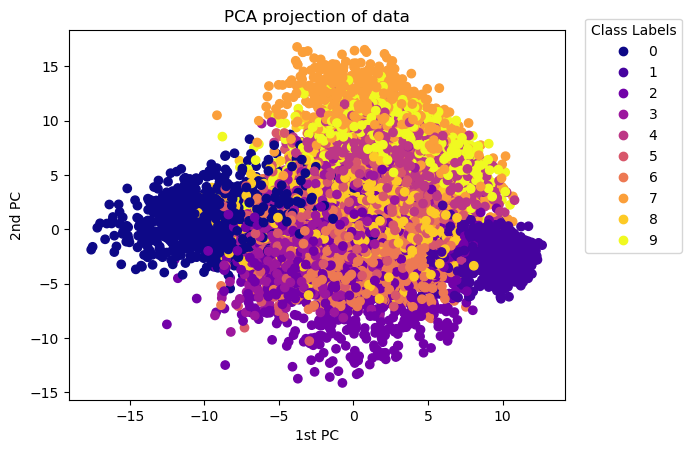

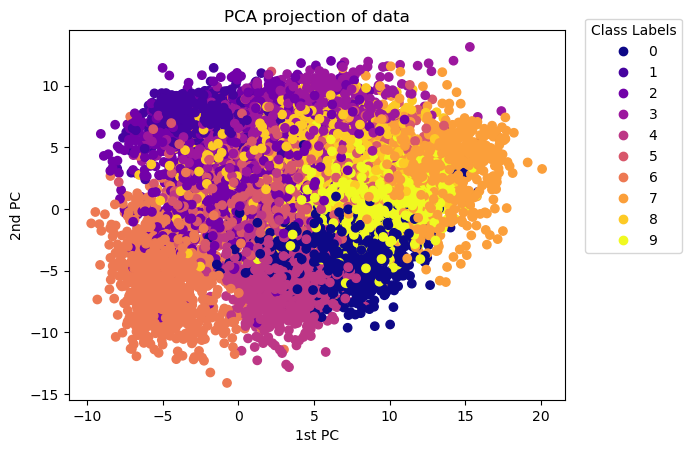

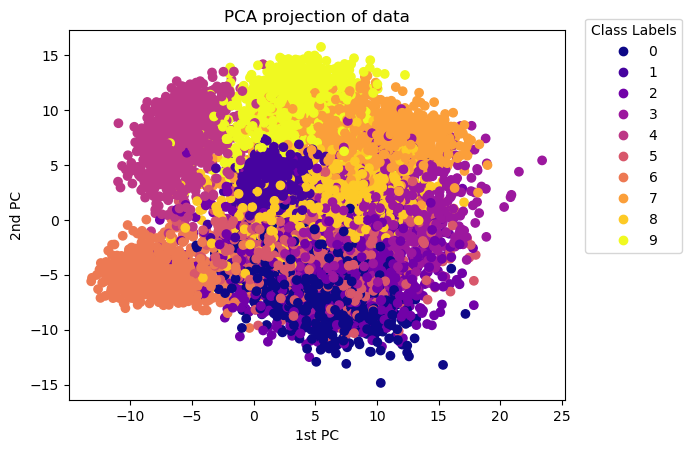

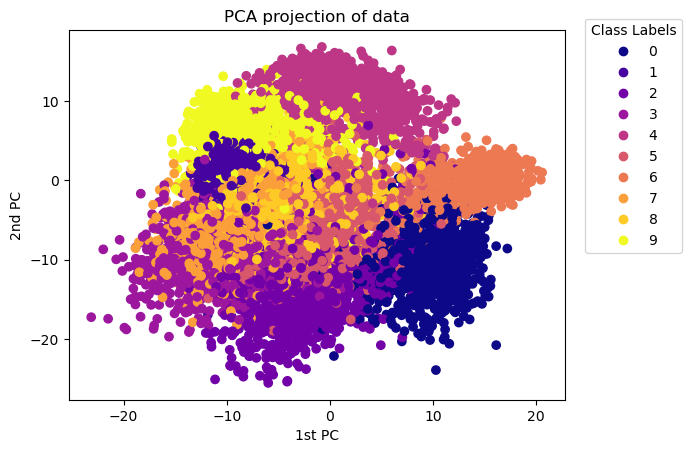

In [49]:
def pca(vectors):
    cov = np.cov(vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:,sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

for i,act in enumerate(acts):
    
    eigenvecs = pca(act)
    
    print(eigenvecs.shape, labels[i].shape)
    plot_projection(eigenvecs, (act, labels[i]), convert_to_vectors=False)
    